In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.optimize import curve_fit
from scipy.ndimage import center_of_mass

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [2]:
def import_img(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

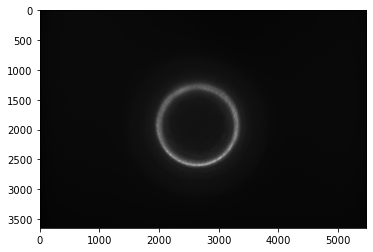

In [3]:
# Imports image to be processed
image = cv2.imread('sample0(10)1.png', cv2.IMREAD_GRAYSCALE)
processedimg = cv2.convertScaleAbs(image, alpha=3, beta=0)
output = image.copy()

plt.imshow(processedimg, cmap='gray')

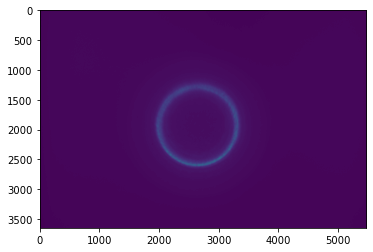

In [19]:
plt.imshow(image)

In [14]:
def circlefinderplot(min, plot=True):
    # Binarizes Image
    img = cv2.threshold(image, min, 189, cv2.THRESH_BINARY)[1]
    # Detects the contours on the binary image using cv2.CHAIN_APPROX_NONE and extracts the outer and inner contours of annulus
    cnts, hier = cv2.findContours(image=img.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    cnts = sorted(cnts, key=len)
    outer = cnts[-1] # outer diameter contour
    inner = cnts[-2] # inner diameter contour

    # Initialize variables
    cx = list()
    cy = list()
    radii = list()
    # Finds center of mass and inner and outer circle radii
    for i in [inner, outer]:
        M = cv2.moments(i)

        cx.append(int(M['m10']/M['m00']))
        cy.append(int(M['m01']/M['m00']))
    
        area = cv2.contourArea(i)
        rad = int((area/np.pi)**(1/2))
        radii.append(rad)

    cx = sum(cx)/2
    cy = sum(cy)/2
    if plot==True:
        # Plots image and overlays the inner and outer circles of the annulus
        plt.figure(figsize=(15,15))
        ax = plt.gca()
        for rad in radii:
            circle = plt.Circle((cx, cy), rad, fill=False, color='red')
            ax.add_artist(circle)

        ax.imshow(output, cmap='gray')
        plt.plot(cx, cy, marker='o', markersize=10, color='red')
        plt.plot(y, x, marker='x', markersize=30)
    else:
        pass
    # Function outputs center of mass coordinates and radii
    print(cx, cy)
    return cx, cy, radii

w = interactive(circlefinderplot, min=(1,50,1)) # Interactive slider to change minimum intensity threshold 
display(w)

interactive(children=(IntSlider(value=25, description='min', max=50, min=1), Checkbox(value=True, description=…

In [11]:
def circlefinder(img_path, min, max=180):
    image = import_img(img_path)
    # Binarizes Image
    img = cv2.threshold(image, min, max, cv2.THRESH_BINARY)[1]
    # Detects the contours on the binary image using cv2.CHAIN_APPROX_NONE and extracts the outer and inner contours of annulus
    cnts, hier = cv2.findContours(image=img.copy(), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    cnts = sorted(cnts, key=len)
    outer = cnts[-1] # outer diameter contour
    inner = cnts[-2] # inner diameter contour

    # Initialize variables
    cx = list()
    cy = list()
    radii = list()
    # Finds center of mass and inner and outer circle radii
    for i in [inner, outer]:
        M = cv2.moments(i)

        cx.append(int(M['m10']/M['m00']))
        cy.append(int(M['m01']/M['m00']))
    
        area = cv2.contourArea(i)
        rad = int((area/np.pi)**(1/2))
        radii.append(rad)

    cx = sum(cx)/2
    cy = sum(cy)/2
    # Function outputs center of mass coordinates and radii
    return cx, cy, radii, image

In [95]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


def lorentzian(x, *p):
    a, x0 , gam = p
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def asym_gauss (x, *p):
    """ Asymmetric Gaussian function with variable continuum level .
    Input :
    x - x- values ( radii )
    *p - parameters [ Amplitude , mean value , standard deviation ,
    constant left , constant right ]
    Output :
    f - y- values , fitted values of assymmetric Gaussian """
    A, mu , sigma , Kl , Kr = p
    f = np.zeros(len(x)) # initializing the array with the result
    cut = np.argmax(x > mu) # find x corresponding to the mean value
    f[0:cut]=(A-Kl)*np.exp(-(x[0:cut]-mu)**2/(2.*sigma**2)) + Kl
    f[cut:] = (A-Kr)*np.exp(-(x[cut:]-mu)**2/(2.*sigma**2)) + Kr

    return f

In [96]:
def radial_profile(data, center):
    """ Bins pixel values radially around a given point
    Input:
    data - array-like, A grayscale image
    center - array-like, The x and y coordinates to bin radially around
    Output:
    radialprofile - A list of the binned intensity values
    """
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int64)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

def cross_slice(imgdata, padding=200):
    cx, cy, radii, image = imgdata
    size = np.shape(image)
    inner = radii[0]
    outer = radii[1]
    rngmin = int(cx-outer-padding)
    rngmax = int(cx+outer+padding)


    
    data = radial_profile(image, (cx, cy))
    
    datalength = len(data)
    xdata = np.linspace(1, datalength, datalength)

    p0 = [max(data), np.argmax(data), 50., 70, 50] # A, mu, sigma, Kl, Kr

    coeff, var_matrix = curve_fit(asym_gauss, xdata, data, p0=p0)
    fitdata = asym_gauss(xdata, *coeff)

    mean = coeff[1]
    fwhm = 2*np.sqrt(2*np.log(2))*coeff[2]
    half_width = fwhm/2

    inner_rad = mean-half_width
    outer_rad = mean+half_width

    fig, ax = plt.subplots(1, 2, figsize=(15,6), tight_layout=True)

    midcircle = plt.Circle((cx, cy), mean, fill=False, color='red', linestyle='dashed')
    innercircle = plt.Circle((cx, cy), inner_rad, fill=False, color='green')
    outercircle = plt.Circle((cx, cy), outer_rad, fill=False, color='green')
    ax[0].add_artist(midcircle)
    ax[0].add_artist(innercircle)
    ax[0].add_artist(outercircle)

    ax[0].imshow(image, cmap='gray')

    ax[1].plot(data, label='Original Data', color='green')
    ax[1].plot(fitdata, label='Fitted Data', linestyle='--', color='red')
    
    ax[1].legend()

    return xdata, data, coeff, half_width

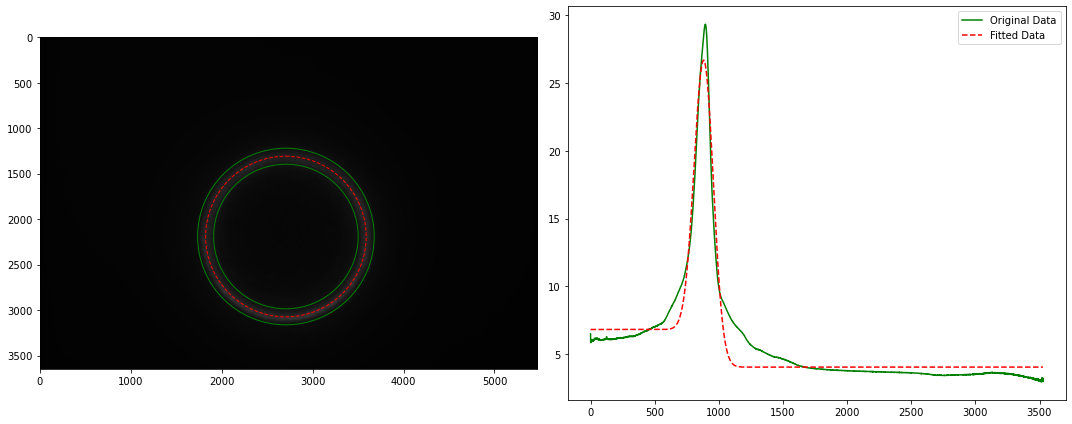

In [105]:
data_axis, data, coeff1, half_width1 = cross_slice(circlefinder('./sample1(10.5).png', 10, 189))

In [106]:
# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted mean = ', coeff1[1])
print('Fitted standard deviation = ', coeff1[2])
print('Half-width 1 = ', half_width1)

Fitted mean =  882.8809817445108
Fitted standard deviation =  74.81220731977974
Half-width 1 =  88.08464270481423


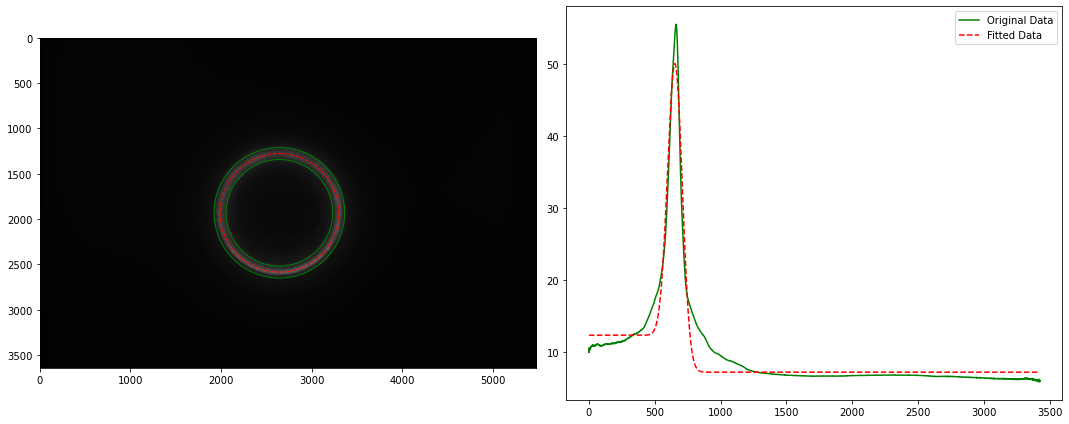

In [107]:
data_axis, data, coeff2, half_width2 = cross_slice(circlefinder('./sample0(10).png', 25, 189))

In [108]:
# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted mean = ', coeff2[1])
print('Fitted standard deviation = ', coeff2[2])
print('Half-width 2 = ', half_width2)

Fitted mean =  653.9106063462189
Fitted standard deviation =  55.74924787337688
Half-width 2 =  65.63972319381345


In [117]:
distance1=10.5 #mm
distance2=10 #mm
deltad=(distance1-distance2)
##pixel size 2.4microns
radius1=coeff1[1]*2.4*10**-3 
radius2=coeff2[1]*2.4*10**-3
deltaw=(half_width1-half_width2)*2.4*10**-3
theta_out=np.arctan((radius1-radius2)/deltad)
theta_exp=np.arctan((deltaw*np.cos(theta_out)**2)/deltad)
FRD=theta_exp/theta_out
print('Theta out = ',theta_out)
print('Theta exp = ',theta_exp)
print('FRD = ',FRD)


Theta out =  0.8325547326932047
Theta exp =  0.048756222572725307
FRD =  0.058562182951029974
